### reference for implementation


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet101
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Background
This paper was published in 2016. At that time, segmentation was not as powerful. FCN (Fully Convolutional Network) did not provide enough performance for complicated semantic segmentation tasks. Thus, they introduced a novel method called the pyramid pooling module. This method gave the ability to understand global contextual priors.

## Model architecture
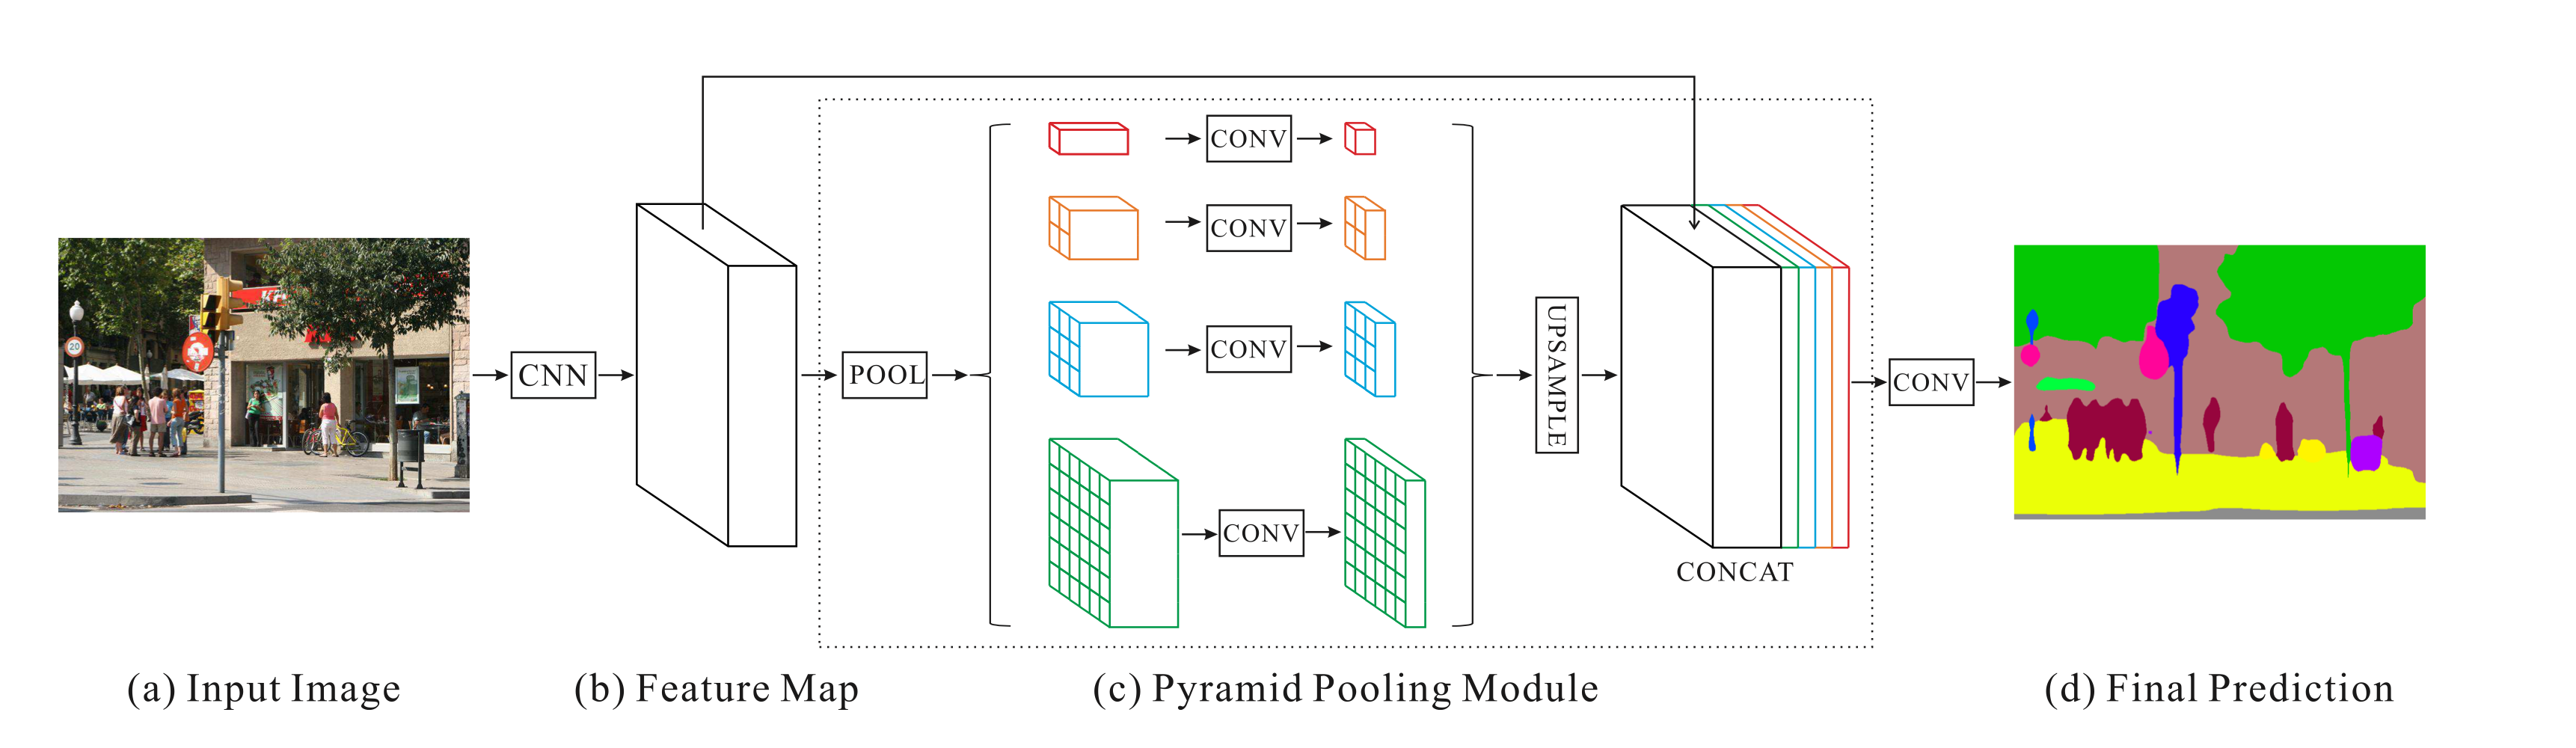

This model architecture uses a Pyramid pooling module. It employs four types of global average pooling (1x1, 2x2, 3x3, 6x6). It uses bilinear upsampling for the prediction image and a pre-trained ResNet model.
So, I will try to implement Three steps:

1. Make the feature map
2. Make the sub-feature maps and concatenate
3. Make the PspNet
    - use two loss

And I will create visualizations.

## Implementation


### First step: Make the feature map
- Load pre-trained ResNet
- Modify layers to use dilated convolutions for maintaining spatial resolution
- Create the feature map using the modified ResNet
- Return the feature map for later concatenation

In [2]:
class ResNet101Backbone(nn.Module):
    def __init__(self,):
        super(ResNet101Backbone, self).__init__()
        resnet = resnet101(pretrained=True)
        
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_aux = self.layer3(x)
        x = self.layer4(x_aux)
        return x_aux, x

## Second step: Make the sub-feature maps

- Make the sube-feautre about global average pooling.
- Use 1x1 conv for reduce channel by pyramid level

In [3]:
class PSPModule(nn.Module):
    def __init__(self, in_channels, out_channels=1024, sizes=(1, 2, 3, 6)):
        super(PSPModule, self).__init__()
        self.stages = nn.ModuleList([self._make_stage(in_channels, size) for size in sizes])
        self.bottleneck = nn.Conv2d(in_channels * (len(sizes) + 1), out_channels, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.interpolate(input=stage(feats), size=(h, w), mode='bilinear', align_corners=True) for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


## Third step: Make the sub-feature maps

- Combination Moudle
- Used the two loss

In [4]:

class PSPNet(nn.Module):
    def __init__(self, num_classes):
        super(PSPNet, self).__init__()
        self.backbone = ResNet101Backbone()
        
        self.psp = PSPModule(2048, 1024)
        
        self.final = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )
        
        self.aux = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.size()[2:]
        x_aux, x = self.backbone(x)
        x = self.psp(x)
        x = self.final(x)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

        if self.training:
            aux = self.aux(x_aux)
            aux = F.interpolate(aux, size=input_size, mode='bilinear', align_corners=True)
            return x, aux
        else:
            return x

In [5]:
model = PSPNet(num_classes=21)

transform = transforms.Compose([
    transforms.Resize((473, 473)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.Resize((473, 473), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, 
                                transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, 
                              transform=transform, target_transform=target_transform)

/Users/youngjaean/anaconda3/envs/pytorch_dev/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/youngjaean/anaconda3/envs/pytorch_dev/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [6]:

def train_pspnet(model, train_loader, val_loader, num_epochs=1, learning_rate=0.01, weight_decay=1e-4):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        print("epcho:",epoch)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            outputs, aux_outputs = model(images)

            loss = criterion(outputs, masks) + 0.4 * criterion(aux_outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            train_accuracy += (predicted == masks).float().mean().item()
            if batch_idx % 100 == 0:
                print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}')
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_accuracy = 0.0, 0.0

        with torch.no_grad():
             for batch_idx, (images, masks) in enumerate(val_loader):
                images, masks = images.to(device), masks.squeeze(1).long().to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_accuracy += (predicted == masks).float().mean().item()
                if batch_idx % 100 == 0:
                    print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}')
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        scheduler.step()
    torch.save(model.state_dict(), 'pspnet_final.pth')


In [7]:

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


num_epochs = 1
train_pspnet(model, train_loader, val_loader, num_epochs=num_epochs)


epcho: 0
Batch: 0, Loss: 4.2739


python(51807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Batch: 0, Loss: 0.2228
Epoch 1/1
Train Loss: 0.4831, Train Accuracy: 0.9318
Val Loss: 0.2126, Val Accuracy: 0.9448
